In [3]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import sys
sys.path.insert(1, '../../SyMBac/')
from matplotlib.ticker import MaxNLocator

from matplotlib import rc
rc('text', usetex=True)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from microfilm.colorify import cmaps_def
import scipy
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
colony_plot_data = pd.read_pickle("../../microcolony_analysis_giant_lorentz/cell_data_giant_lorentz.pickle")#pd.read_pickle("../../microcolony_analysis/microcolony_plotting_data.pickle")

colony_plot_data["Intensity foldchange"] = colony_plot_data["Mean observed intensity"]/colony_plot_data.query("`Colony N cells` == 1")["Mean observed intensity"].mean()

def bin_data_range(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in ([f"[{int(x.left+1)}, {int(x.right+1)})"  for x in pd.cut(df[column], bins=bins).unique()]) ])


def bin_data_mid(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])

data = pd.read_pickle("../../microcolony_analysis/real_data_segmentation_notebooks/agar_pad_with_deconv.pickle")
max_sim_size = colony_plot_data["Colony N cells"].max()
data = data.query("`Colony N cells` <= @max_sim_size")
data["Distance from centre of colony"] = np.sqrt(
    (data["Cell y"] - data["Colony centroid y"])**2 + (data["Cell x"] - data["Colony centroid x"])**2 
)
data["Normalised distance from centre of colony"] = data["Distance from centre of colony"] / (data["Colony diameter"]/2)
data["Mean true intensity"] = data["True intensity"] / data["Area"]
data["Mean observed intensity"] = data["Observed intensity"] / data["Area"]

data["Mean deconvolved intensity"] = data["Deconvolved intensity"] / data["Area"]

data = data[(data["Mean true intensity"] > 0)]
data["Colony N cells (binned)"] = bin_data_range(bins = 3, df=data, column="Colony N cells", new_column_name="Colony N cells (binned)")
data["Normalised distance from centre of colony (binned)"] = bin_data_mid(bins=19, df = data, column = "Normalised distance from centre of colony", new_column_name=None)
div_frac = data.query("`Colony N cells` == 1")["Mean observed intensity"].mean() / colony_plot_data.query("`Colony N cells` == 1")["Mean observed intensity"].mean()
data["Mean observed intensity"] = data["Mean observed intensity"]*0.0025
data["Intensity foldchange"] = data["Mean observed intensity"] / data.query("`Colony N cells` == 1")["Mean observed intensity"].mean()# 4.2*0.003



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile


def bin_data_range(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in ([f"[{int(x.left+1)}, {int(x.right+1)})"  for x in pd.cut(df[column], bins=bins).unique()]) ])


def bin_data_mid(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])
from matplotlib_scalebar.scalebar import ScaleBar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from microfilm.colorify import cmaps_def
import scipy
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
from numba import njit

@njit
def get_CV(arr):
    return arr.std()/arr.mean()


@njit()
def get_intensities(img, mask):
    mask_labels = np.unique(mask)
    mean_intensities = []
    total_intensities = []
    for l, mask_label in enumerate(mask_labels[1:]):
        idxs = np.where(mask == mask_label)
        if len(idxs[0]) > 100:
            pixel_intensities = np.zeros(len(idxs[0]))
            for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                pixel_intensities[k] = img[i,j]
            mean_intensity = np.mean(pixel_intensities)
            total_intensity = np.sum(pixel_intensities)
            mean_intensities.append(mean_intensity)
            total_intensities.append(total_intensity)
    mean_intensities = np.array(mean_intensities)
    total_intensities = np.array(total_intensities)
    return mean_intensities, total_intensities


def get_CV_from_img_mask(img, mask):
    mean_intensities, total_intensities = get_intensities(img,mask)
    return get_CV(mean_intensities), get_CV(total_intensities)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_1528994/2375448902.py:59: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [13]:
from glob import glob

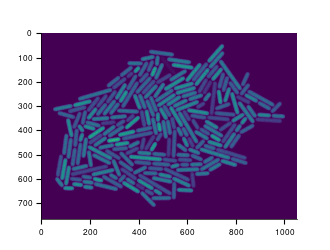

In [163]:
large_colony = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D//03476.tif").sum(axis=0)
large_colony_size = large_colony.shape
plt.imshow(large_colony)

In [164]:
large_colony_size

(767, 1053)

In [165]:
frame_3.shape

(831, 924)

In [166]:
def pad_to_large_colony(frame):
    frame = np.pad(frame, (
        ((large_colony_size[0] - frame.shape[0])//2,(large_colony_size[0] - frame.shape[0])//2),
        ((large_colony_size[1] - frame.shape[1])//2,(large_colony_size[1] - frame.shape[1])//2))
          )
    return frame

In [175]:
def plot_dir(dir):
    fig, ax  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 600)
    frame_0 = tifffile.imread(dir).sum(axis=0)
    frame_0 = pad_to_large_colony(frame_0)
    plt.imshow(frame_0, cmap="Greys_r")
    scalebar = ScaleBar(0.05, "um", label_loc=None, scale_loc = "none", box_alpha=0, color="white", length_fraction=0.25) # 10 micron
    ax.add_artist(scalebar)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

In [176]:
idxs = ["00001", "00020", "00025", "00030", "00032"]

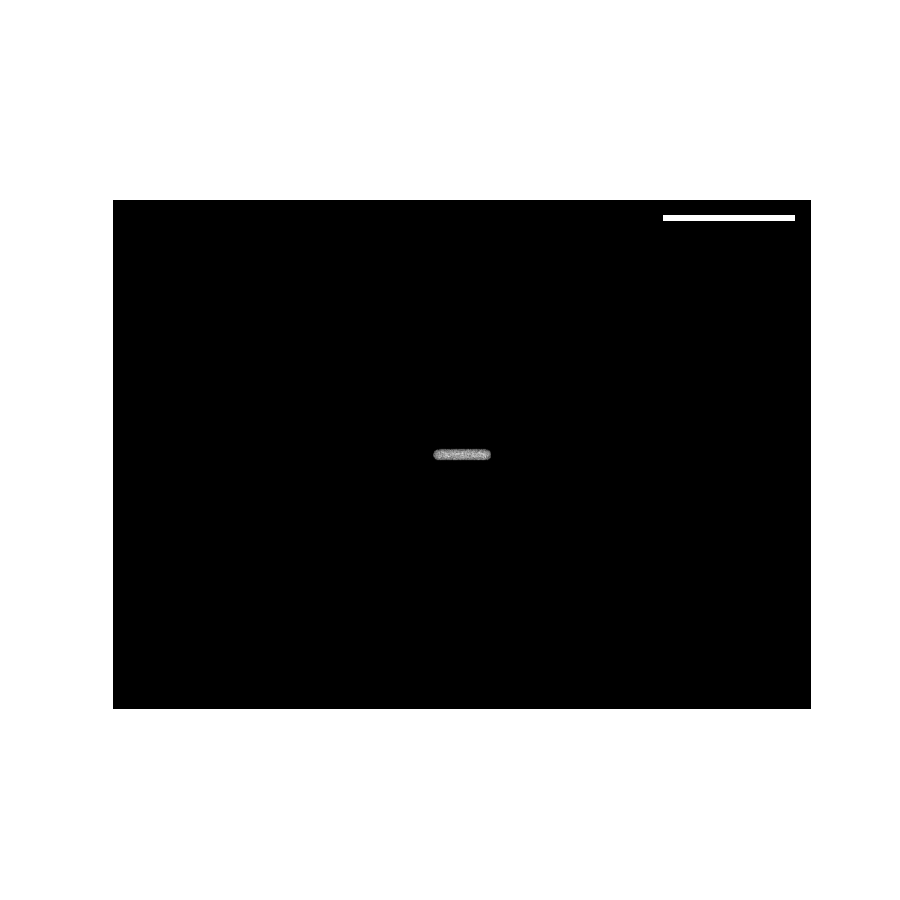

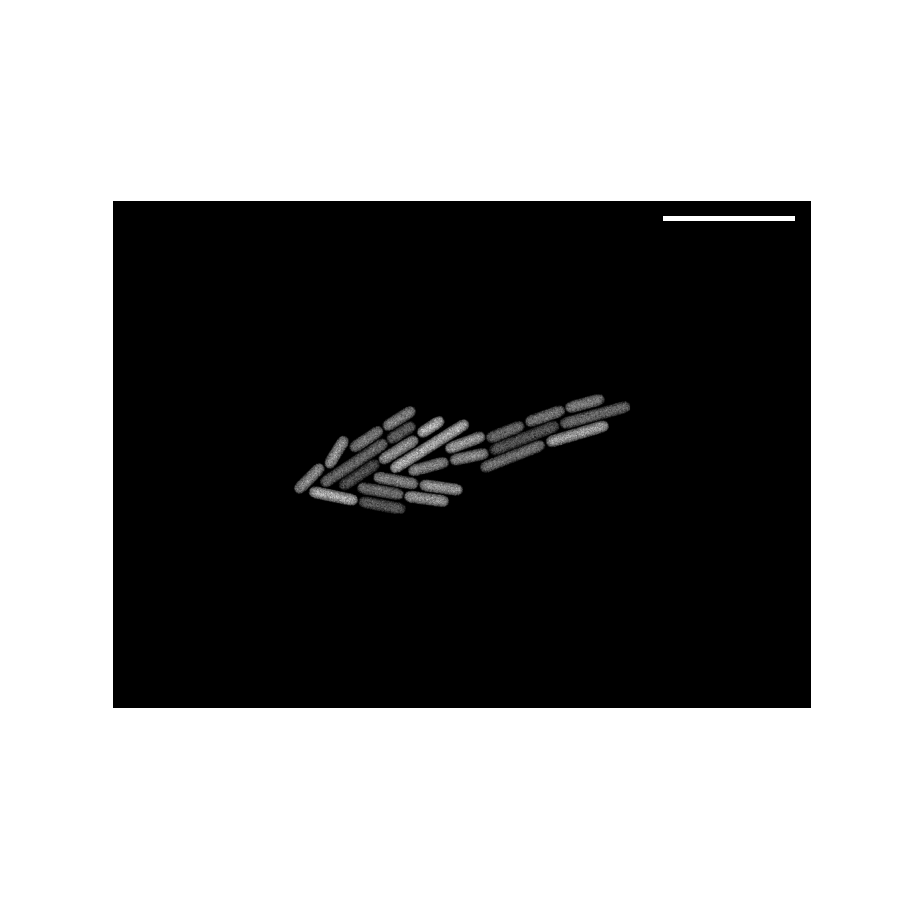

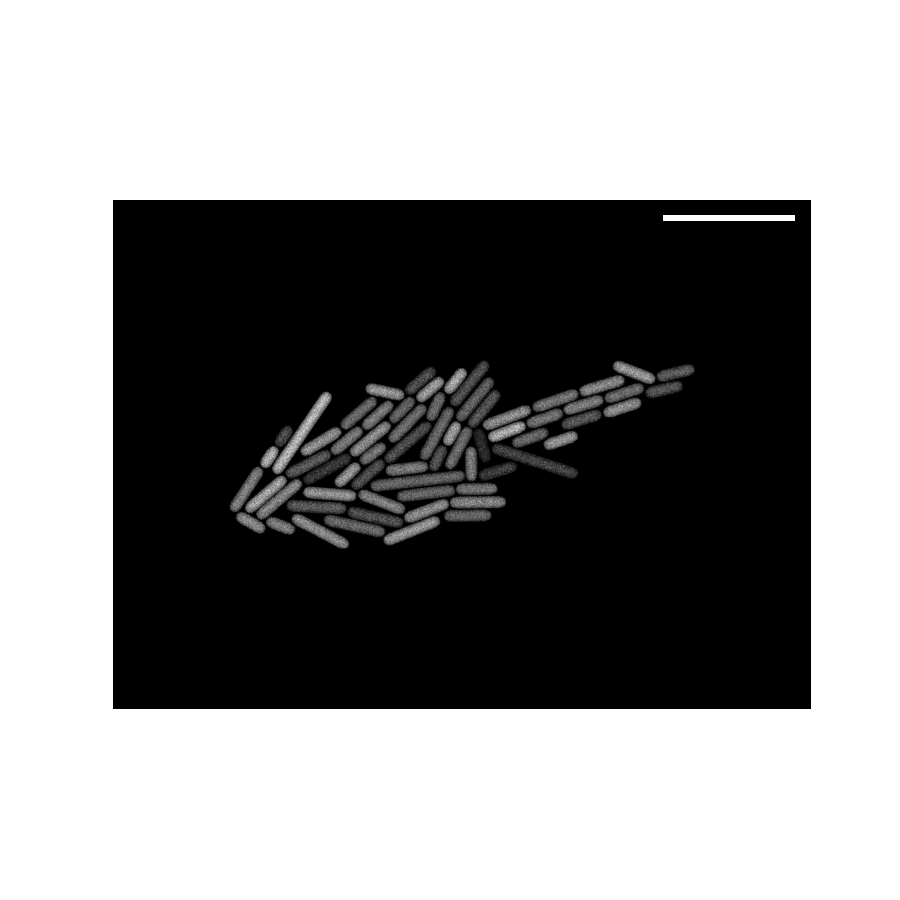

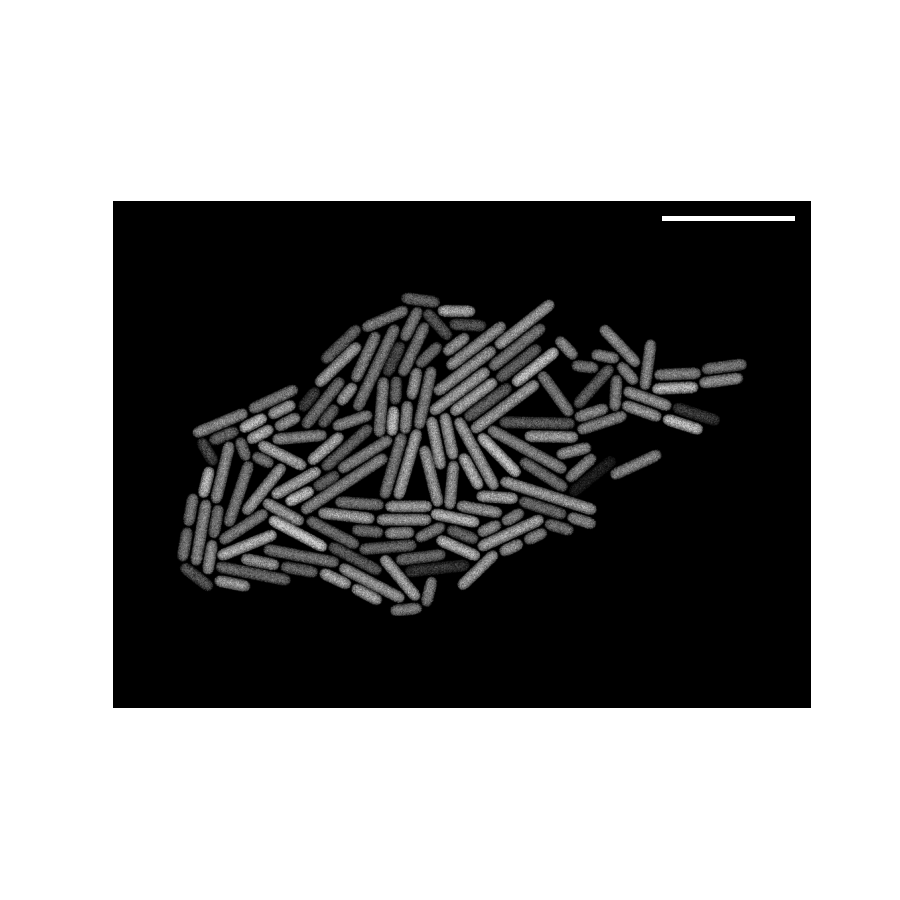

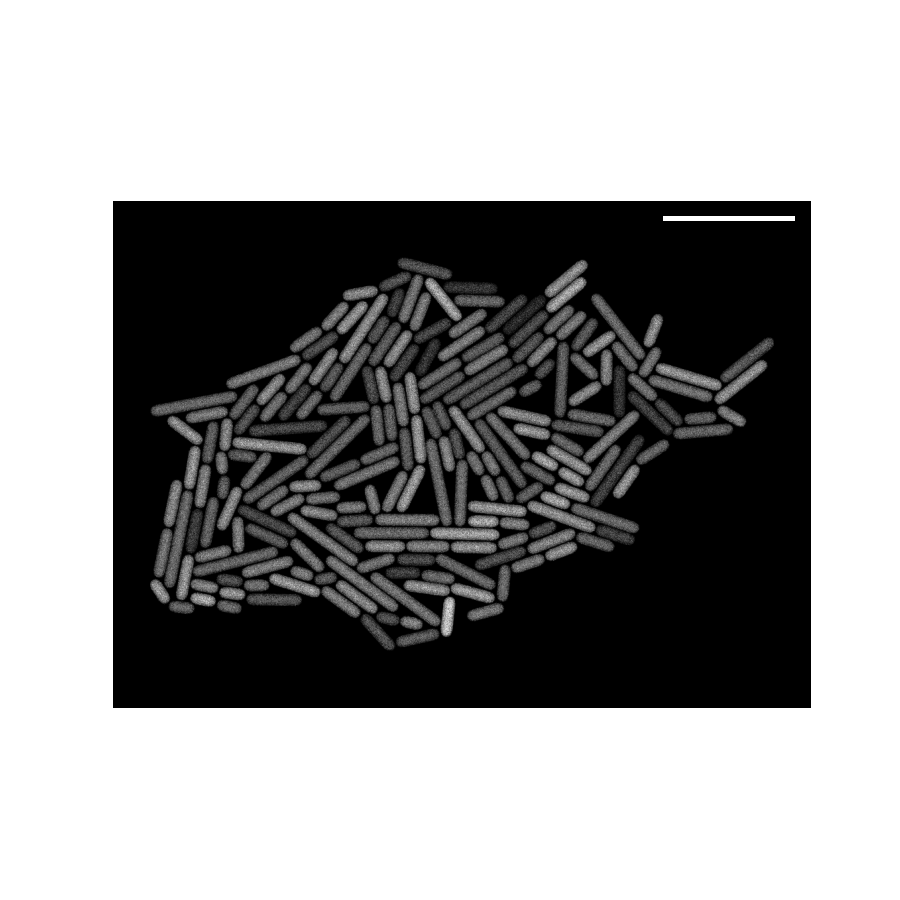

In [177]:
idxs = ["03446", "03463", "03468", "03473", "03475"]
for idx in idxs:
    plot_dir(f"../../microcolony_analysis/data/fluorescent_scenes_3D//{idx}.tif")

In [206]:
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from skimage.transform import rescale

In [244]:
pix_mic_conv = 0.

size: 104


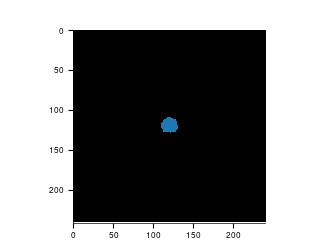

In [306]:
real_PSF = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag.tif").astype(np.float32)
label_image = cle.voronoi_otsu_labeling(real_PSF)
imshow(label_image, labels=True)
stats = cle.statistics_of_labelled_pixels(real_PSF, label_image)

df = pd.DataFrame(stats)
df[["mass_center_x", "mass_center_y", "mass_center_z"]]
pix_mic_conv = 0.05
real_PSF = rescale(real_PSF, ((0.05) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv)  , anti_aliasing=True)
real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
real_PSF -= real_PSF.min()
real_PSF = real_PSF / np.sum(real_PSF)



In [307]:
post_scaling = np.sum(real_PSF,axis=(1,2))

In [308]:
for layer, scale in zip(real_PSF, post_scaling):
    layer -= layer.min()
    layer *= scale

In [309]:
PSF_mid = real_PSF.shape[0]//2

In [310]:
real_PSF.shape

(104, 210, 210)

In [311]:
dir = f"../../microcolony_analysis/data/fluorescent_scenes_3D//03475.tif"
frame_0 = tifffile.imread(dir)
frame_mid = frame_0.shape[0]//2

In [312]:
from SyMBac.renderer import convolve_rescale

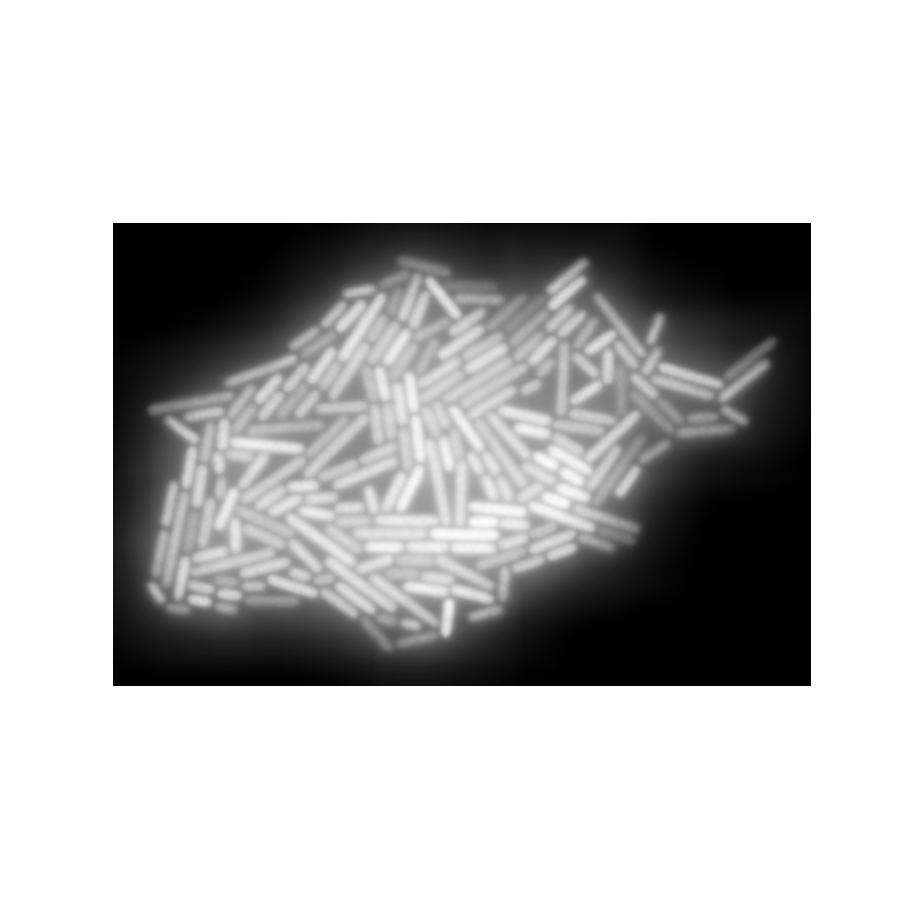

In [343]:
full_convolution = np.array([convolve_rescale(frame_0[idx].astype(float), real_PSF[PSF_mid-frame_mid+idx], 1, False) for idx in range(frame_mid)]).sum(axis=0)
fig, ax  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 600)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.imshow(full_convolution, cmap="Greys_r",)
vmax = full_convolution.max()/8
vmin = full_convolution.min()*2

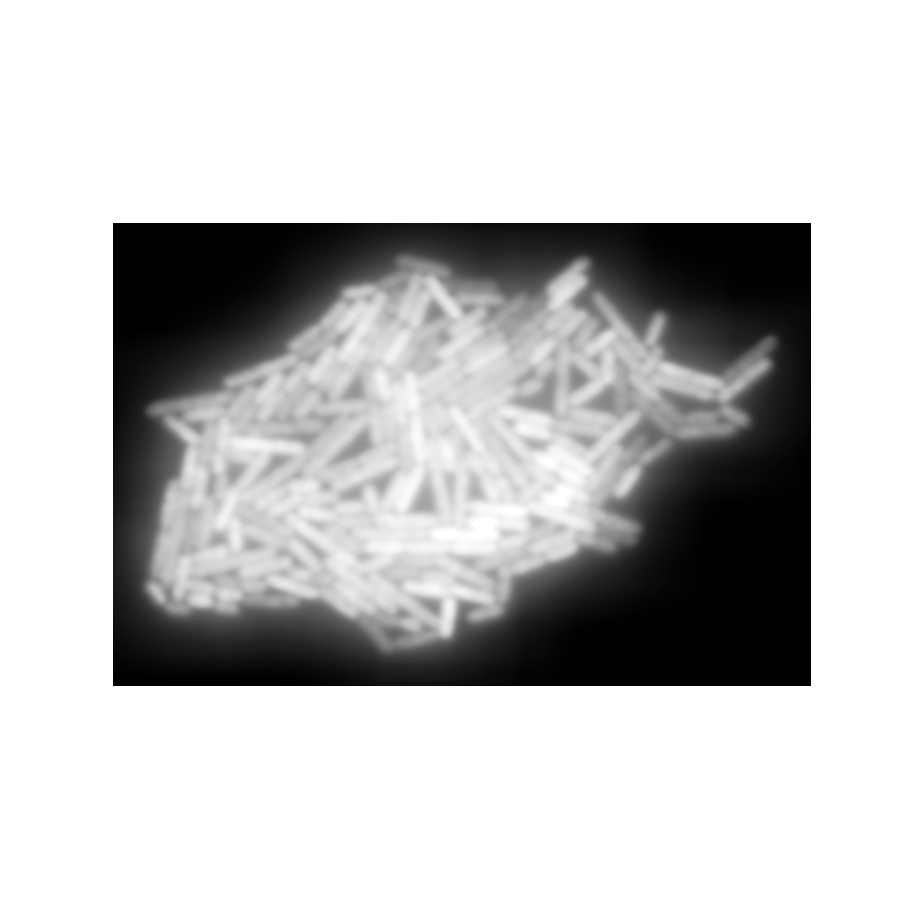

In [344]:
mid_convolution = convolve_rescale(frame_0[frame_mid].astype(float), real_PSF[PSF_mid], 1, False)
fig, ax  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 600)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.imshow(mid_convolution, cmap="Greys_r", vmax = vmax, vmin = vmin)

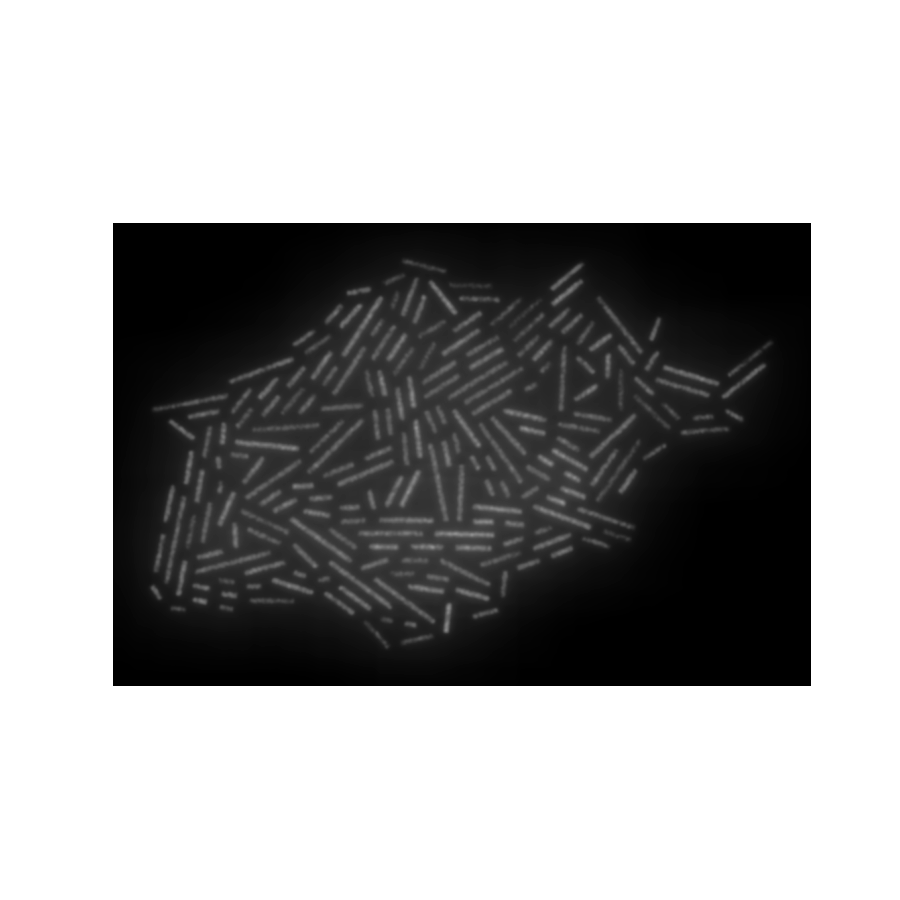

In [345]:
top_convolution = convolve_rescale(frame_0[0].astype(float), real_PSF[PSF_mid-frame_mid], 1, False)
fig, ax  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 600)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.imshow(top_convolution, cmap="Greys_r", vmin = vmin, vmax = vmax)

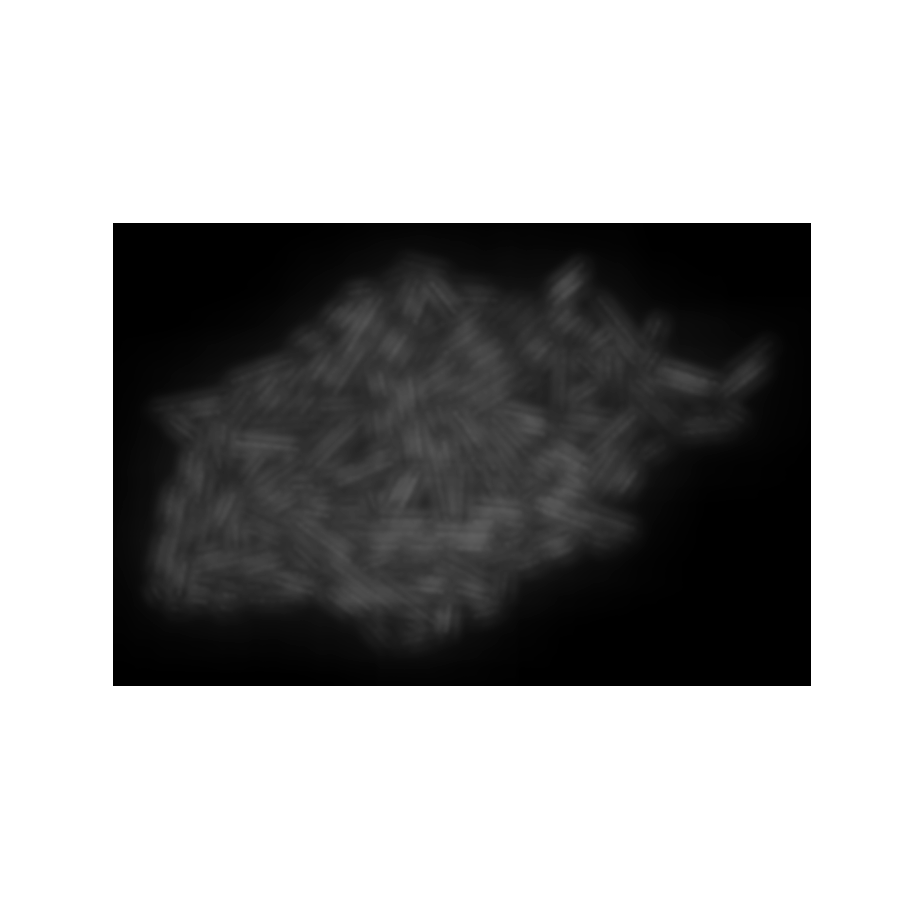

In [346]:
bottom_convolution = convolve_rescale(frame_0[-1].astype(float), real_PSF[PSF_mid+frame_mid], 1, False)
fig, ax  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 600)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.imshow(bottom_convolution, cmap="Greys_r", vmin = vmin, vmax = vmax)

In [ ]:
len(glob(f"../../microcolony_analysis/data/fluorescent_scenes_3D//*.tif"))
plt.imshow(tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D//02940.tif").sum(axis=0))

In [ ]:
len(glob(f"../../microcolony_analysis/data/fluorescent_scenes_3D//*.tif"))
plt.imshow(tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D//02940.tif").sum(axis=0))

In [10]:
colony_ID_low_CV = 315
colond_ID_mid_CV = colony_ID_low_CV + 315
colony_ID_high_CV = colony_ID_low_CV + 2844

low_CV_unconv = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D//{str(colony_ID_low_CV+1).zfill(5)}.tif").sum(axis=0)
high_CV_unconv = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D//{str(colony_ID_high_CV+1).zfill(5)}.tif").sum(axis=0)
mid_CV_unconv = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D//{str(colond_ID_mid_CV+1).zfill(5)}.tif").sum(axis=0)

low_CV_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_empirical_PSF/training_data_100x_0.55_green_1.49_1.518//synth_imgs/{str(colony_ID_low_CV).zfill(4)}.tif")
high_CV_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_empirical_PSF/training_data_100x_0.55_green_1.49_1.518/synth_imgs/{str(colony_ID_high_CV).zfill(4)}.tif")

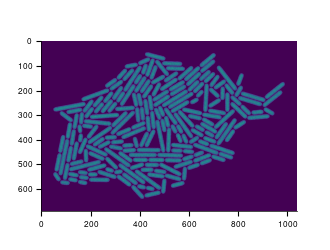

In [11]:
plt.imshow(mid_CV_unconv)

/tmp/ipykernel_1528994/4046410205.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  a = matplotlib.cm.get_cmap('Set2')


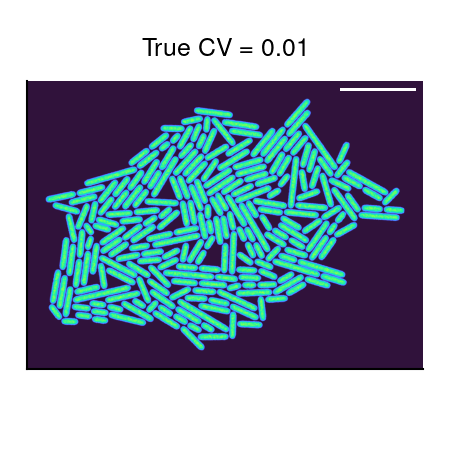

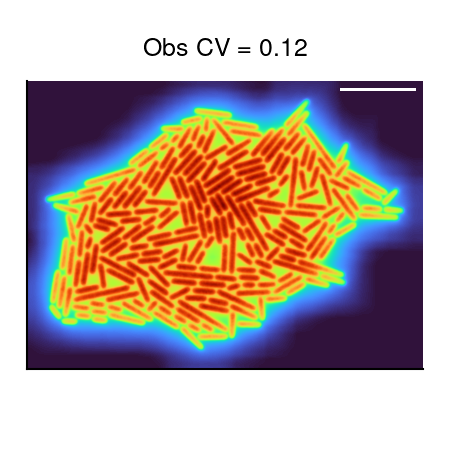

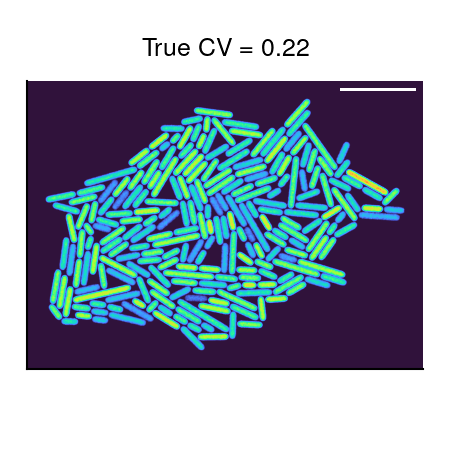

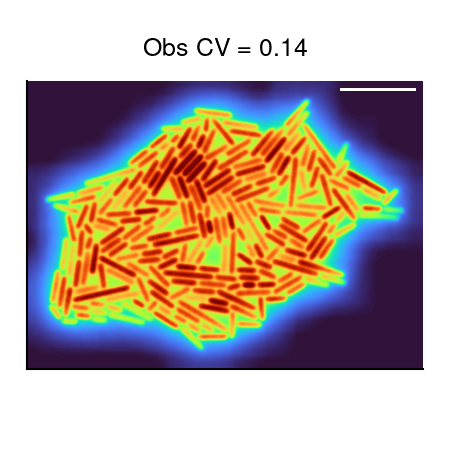

In [8]:
colony_plot_data = pd.read_pickle("../../microcolony_analysis/microcolony_plotting_data.pickle")

mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_low_CV+1).zfill(5)}.png"))

CV_low_CV_conv = get_CV_from_img_mask(low_CV_conv, mask)[0]

#mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_low_CV+1).zfill(5)}.png"))

CV_low_CV_unconv = get_CV_from_img_mask(low_CV_unconv, mask)[0]

mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_high_CV+1).zfill(5)}.png"))

CV_high_CV_conv =  get_CV_from_img_mask(high_CV_conv, mask)[0]

mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_high_CV+1).zfill(5)}.png"))

CV_high_CV_unconv = get_CV_from_img_mask(high_CV_unconv, mask)[0]




cmap="turbo"


cm = 1/2.54
a = matplotlib.cm.get_cmap('Set2')

fig, LOW_CV_UNCONV  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(gaussian_filter(low_CV_unconv,1), cmap=cmap, vmin=0, vmax = high_CV_unconv.max()*0.9  )
#LOW_CV_UNCONV.annotate( f'True CV = {CV_low_CV_unconv:.2f}', (1030,768), ha='right', va='top', transform=LOW_CV_UNCONV.transAxes, c="black")
scalebar = ScaleBar(0.05, "um", label_loc=None, scale_loc = "none", box_alpha=0, color="white", length_fraction=0.25) # 10 micron
LOW_CV_UNCONV.add_artist(scalebar)
LOW_CV_UNCONV.set_xticks([])
LOW_CV_UNCONV.set_yticks([])
plt.title(f'True CV = {CV_low_CV_unconv:.2f}')
plt.tight_layout()
plt.savefig("f.svg")
plt.show()
plt.close() 

fig, LOW_CV_CONV  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(low_CV_conv, cmap=cmap, vmin=0,vmax = high_CV_conv.max()*0.9 ) 
#LOW_CV_CONV.annotate( f'Obs CV = {CV_low_CV_conv:.2f}', (1030,650), ha='right', va='top', transform=LOW_CV_CONV.transAxes, c="white")
scalebar = ScaleBar(0.05, "um", label_loc=None, scale_loc = "none", box_alpha=0, color="white", length_fraction=0.25) # 10 micron
LOW_CV_CONV.add_artist(scalebar)
LOW_CV_CONV.set_xticks([])
LOW_CV_CONV.set_yticks([])
plt.title(f'Obs CV = {CV_low_CV_conv:.2f}')
plt.tight_layout()
plt.savefig("g.svg")
plt.show()
plt.close()

fig, HIGH_CV_UNCONV  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(gaussian_filter(high_CV_unconv,1), cmap=cmap, vmin=0, vmax = high_CV_unconv.max()*0.9)
#HIGH_CV_UNCONV.annotate( f'True CV = {CV_high_CV_unconv:.2f}', (1030,650), ha='right', va='top', transform=HIGH_CV_UNCONV.transAxes, c="white")
scalebar = ScaleBar(0.05, "um", label_loc=None, scale_loc = "none", box_alpha=0, color="white", length_fraction=0.25) # 10 micron
HIGH_CV_UNCONV.add_artist(scalebar)
HIGH_CV_UNCONV.set_xticks([])
HIGH_CV_UNCONV.set_yticks([])
plt.title(f'True CV = {CV_high_CV_unconv:.2f}')
plt.tight_layout()
plt.savefig("h.svg")
plt.show()
plt.close()

fig, HIGH_CV_CONV  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(high_CV_conv, cmap=cmap, vmin=0,vmax = high_CV_conv.max()*0.9 )
#HIGH_CV_CONV.annotate( f'Obs CV = {CV_high_CV_conv:.2f}', (1030,650), ha='right', va='top', transform=HIGH_CV_CONV.transAxes, c="white")
scalebar = ScaleBar(0.05, "um", label_loc=None, scale_loc = "none", box_alpha=0, color="white", length_fraction=0.25) # 10 micron
HIGH_CV_CONV.add_artist(scalebar)
HIGH_CV_CONV.set_xticks([])
HIGH_CV_CONV.set_yticks([])
plt.title(f'Obs CV = {CV_high_CV_conv:.2f}')
plt.tight_layout()
plt.savefig("i.svg")
plt.show()
plt.close()